**Import libraries**

In [40]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import os

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import regularizers

from tensorflow.keras.regularizers import l2

from sklearn.metrics.pairwise import cosine_similarity

In [41]:
dataset_path = '/kaggle/input/cropped-dataset'

num_classes = 105

image_paths = []

labels = []



for class_name in os.listdir(dataset_path):

    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):

        for img_name in os.listdir(class_path):

            img_path = os.path.join(class_path, img_name)

            image_paths.append(img_path)

            labels.append(class_name)


In [42]:
labels = np.array(labels)

label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

In [43]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, numeric_labels, test_size=0.1, stratify=numeric_labels, random_state=42
)
# val_paths, test_paths, val_labels, test_labels = train_test_split(
#     test_val_paths, test_val_labels, test_size=0.5, stratify=test_val_labels, random_state=42
# )

In [44]:
def load_image_dataset(image_paths, labels, img_height=224, img_width=224, batch_size=32):
    def process_image(file_path, label):
        image = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [img_height, img_width])
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: process_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [45]:
train_dataset = load_image_dataset(train_paths, train_labels)

val_dataset = load_image_dataset(val_paths, val_labels)

# test_dataset = load_image_dataset(test_paths, test_labels)

In [46]:
print('Number of Train samples:', len(train_paths))

print('Number of Validation samples:', len(val_paths))

# print('Number of Test samples:', len(test_paths))

Number of Train samples: 15819
Number of Validation samples: 1758


In [47]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [48]:
x = base_model.output

x = Flatten()(x)

x = Dense(1024, activation='relu')(x)

x = BatchNormalization()(x)

x = Dropout(0.2)(x)

x = Dense(512, activation='relu')(x)

x = BatchNormalization()(x)

x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)

x = BatchNormalization()(x)

x = Dropout(0.4)(x)

output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

In [49]:
model.compile(optimizer=Adam(learning_rate=0.0001),

              loss='sparse_categorical_crossentropy',

              metrics=['accuracy'])


In [50]:
history = model.fit(

    train_dataset,  

    validation_data=val_dataset, 

    epochs=10,  

    batch_size=32  

)

Epoch 1/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 160s 214ms/step - accuracy: 0.0502 - loss: 4.8405 - val_accuracy: 0.0159 - val_loss: 4.8587
Epoch 2/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 82s 165ms/step - accuracy: 0.2926 - loss: 3.1166 - val_accuracy: 0.4545 - val_loss: 2.5443
Epoch 3/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 81s 164ms/step - accuracy: 0.6008 - loss: 1.8827 - val_accuracy: 0.6724 - val_loss: 1.6777
Epoch 4/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 81s 164ms/step - accuracy: 0.8399 - loss: 1.0005 - val_accuracy: 0.7463 - val_loss: 1.3195
Epoch 5/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - accuracy: 0.9517 - loss: 0.4802 - val_accuracy: 0.7867 - val_loss: 1.0902
Epoch 6/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 81s 164ms/step - accuracy: 0.9892 - loss: 0.2308 - val_accuracy: 0.8009 - val_loss: 0.9554
Epoch 7/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - accuracy: 0.9979 - loss: 0.1211 - val_accuracy: 0.8441 - val_loss: 0.7393
Epoch 8/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 81s 165ms/step - accuracy: 0.9996 - loss: 

In [51]:
# model.save('face_class_model.keras')

In [52]:
# model.save('face_class_model.h5')

In [53]:
# import shutil

# shutil.make_archive('/kaggle/working/face_class_model', 'zip', '.', 'face_class_model.h5')

In [54]:
class_embeddings = {}
embedding_model = Model(inputs=model.input, outputs=model.layers[-2].output) 
for i, class_name in enumerate(label_encoder.classes_):
    class_images = [img for img, label in zip(train_paths, train_labels) if label == i]

    embeddings = []

    for img_path in class_images:

        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = img / 255.0  
        
        img = tf.expand_dims(img, axis=0)

        embedding = embedding_model.predict(img)
        embeddings.append(embedding[0]) 

    class_embeddings[class_name] = np.mean(embeddings, axis=0)

np.save('class_embeddings.npy', class_embeddings)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

In [62]:
def identify_face(image_path, threshold=0.8):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.expand_dims(img / 255.0, axis=0)

    embedding = embedding_model.predict(img)[0]

    similarities = []
    for class_name, class_embedding in class_embeddings.items():
        similarity = cosine_similarity([embedding], [class_embedding])[0][0]
        similarities.append((class_name, similarity))

    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    
    if similarities[0][1] >= threshold:
        identified_class = similarities[0][0]
    else:
        identified_class = "Not Identified"

    if identified_class != "Not Identified":
        prediction = model.predict(img)  
        class_idx = tf.argmax(prediction, axis=1).numpy()[0]
        identified_class = label_encoder.classes_[class_idx]  

    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title(f"Identified as: {identified_class}")
    plt.axis('off')
    plt.show()

    return identified_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


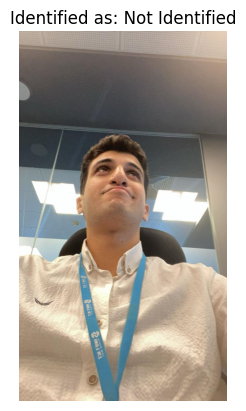

Identified as: Not Identified


In [59]:
unidentified_image_path = '/kaggle/input/my-photo/WhatsApp Image 2024-11-07 at 9.46.26 PM.jpeg'  
result = identify_face(unidentified_image_path)
print(f"Identified as: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


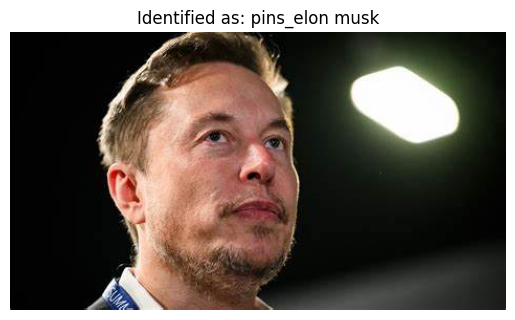

Identified as: pins_elon musk 


In [63]:
unidentified_image_path = '/kaggle/input/ilon-mask/th.jpeg'  
result = identify_face(unidentified_image_path)
print(f"Identified as: {result}")

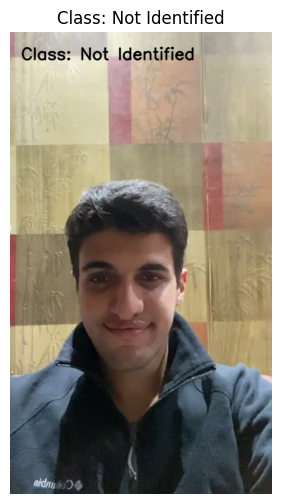

Processed video saved to: /kaggle/working/processed_video_output.mp4


In [57]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time


cap = cv2.VideoCapture("/kaggle/input/my-video/WhatsApp Video 2024-11-08 at 12.45.32 AM.mp4")


plt.ion()
fig, ax = plt.subplots(figsize=(8, 6))


output_video_path = '/kaggle/working/processed_video_output.mp4' 
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_rate = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
out = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    result = identify_face_from_array(frame) 

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, f"Class: {result}", (20, 50), font, 1, (0, 0, 0), 2, cv2.LINE_AA)

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    ax.clear()  
    ax.imshow(frame_rgb)  
    ax.set_title(f"Class: {result}")
    ax.axis('off')  

    plt.pause(0.0)  

    clear_output(wait=True)
    display(fig)

    out.write(frame)

cap.release()
out.release()

plt.ioff()  
plt.show()

print(f"Processed video saved to: {output_video_path}")
